#Numerical Analysis' project

Movie recommendation system

In [977]:
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from numpy.linalg import matrix_rank
from tqdm.notebook import tqdm
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import jax.numpy as jnp
#import jax
import time

Load the dataset using pandas

In [978]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [979]:
# Find all the possible user ids and movie ids-> do that after the deletion
userIds_available = set()
movieIds_available = set()
for id in np.array(ratings['userId'] , dtype = int):
    userIds_available.add(id)

for id in np.array(movies['movieId'] , dtype = int):
    movieIds_available.add(id)
    
userIds_available = list(userIds_available)
movieIds_available = list(movieIds_available)

userIds_available.sort()
movieIds_available.sort()

print(len(userIds_available) , len(movieIds_available))

668 10329


In [980]:
#ratings # 105339 users' ratings , 668 different users
#movies # 10329 movies
rows = np.array(ratings['userId'])
cols = np.array(ratings['movieId'])
vals = np.array(ratings['rating'])

n = rows.max() + 1 # Number of user
p = cols.max() + 1# Number of movies
N = len(vals) # Number of ratings


def binary_search(array , x):
    low = 0
    high = len(array) - 1
    while(high >= low):
        mid = int((high + low) / 2)
        
        if array[mid] == x:
            return mid
        
        elif array[mid] > x:
            high = mid - 1
            
        else:
            low = mid + 1

    print("Element %d not found" % x)
    return -1

# Update the arrays rows/cols with the true position instead of the ids 
for i_user in tqdm(range(len(rows))):
    rows[i_user] = binary_search(userIds_available ,  rows[i_user])

for i_movie in tqdm(range(len(cols))):
    cols[i_movie] = binary_search(movieIds_available , cols[i_movie])

n , p , N

  0%|          | 0/105339 [00:00<?, ?it/s]

  0%|          | 0/105339 [00:00<?, ?it/s]

(669, 149533, 105339)

In [ ]:
# Command for analyse input data matrix 
movies.head()
ratings.head()
movies.info()
ratings.info()
movies.describe()
ratings.describe()
sns.distplot(ratings['rating'])
sns.distplot(ratings['movieId'])
sns.scatterplot(data = ratings , x = 'userId' , y = 'movieId' , hue = 'rating')
ratings.corr()

In [1126]:
# Shuffle the data
indexes = np.arange(N)
np.random.seed(154358372) # for reproducibility
np.random.shuffle(indexes)
indexes
# Reordering the arrays
rows = rows[indexes]
cols = cols[indexes]
vals = vals[indexes]

Building the train set (80%) and the validation set (20%)

In [1127]:
# Split data in training and testing
num_training = int(N * 0.8)

rows_train = rows[:num_training]
cols_train = cols[:num_training]
vals_train = vals[:num_training]
rows_test  = rows[num_training:]
cols_test  = cols[num_training:]
vals_test  = vals[num_training:]

print(len(rows_train) , len(cols_train) , len(vals_train))

84271 84271 84271


Building the matrix with the origina values

Building the 'Ratings matrix'
Users on the rows and Movies on the columns

Initializing all the elements to 0 and then updating position (i,j) with the rating of movie j by user i if it's present

In [1128]:
# Initialize the matrix with all zeros
ratings_matrix = np.zeros((len(userIds_available) , len(movieIds_available)))
print(ratings_matrix)
print("=========================")
# Update the matrix with the known values (contained in vals_train array)
ratings_matrix[rows_train, cols_train] = vals_train
print(ratings_matrix) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  2.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [3.  3.  2.  ... 0.  4.5 0. ]]


In [ ]:
frame = pd.DataFrame(ratings_matrix, index = userIds_available , columns = movieIds_available)
print(frame)

Checking if there are users that haven't watched any movie

In [1129]:
# Count the number of missing values
def count_missing_values(matrix):
    missing_values = 0

    for i_user in tqdm(range(matrix.shape[0])):
        for j_movie in range(matrix.shape[1]):
            # If the movie in position j_movie hasn't a rating
            if matrix[i_user , j_movie] == 0:
                missing_values += 1

    print("There are %d missing valuess" % (missing_values))
    print("There are %d values inserted" % (matrix.shape[0] * matrix.shape[1] - missing_values))
    print("There are %d values" % (matrix.shape[0] * matrix.shape[1]))
    
count_missing_values(ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 6815501 missing valuess
There are 84271 values inserted
There are 6899772 values


Building movie-genre correlation matrix M

$$
M_{i,j} = 
\begin{cases}
1 & \text{if movie i is of genre j}\\
0 & \text{otherwise}
\end{cases}
$$

In [1130]:
# Put in a set all the genres available
genre_available = set()

for i in range(movies.shape[0]):
    genres = movies['genres'][i].split('|')
    for g in genres: genre_available.add(g)

# print("All genres available are: " , id_available , genre_available)

In [1131]:
# Build the matrix
num_movies = len(movieIds_available)
num_genres = len(genre_available)
print("Max movie id: " , max(movies['movieId']))
print("Number of movies is: " , num_movies)
print("Number of genres is: " , num_genres)
# Initialize the matrix with all zeros of int8 type
correlation_matrix = np.zeros((num_movies , num_genres) , dtype = np.int8)

Max movie id:  149532
Number of movies is:  10329
Number of genres is:  20


In [1132]:
# Update the table with the correspondance
for i in tqdm(range(movies.shape[0])):
    id = movies['movieId'][i]
    # Take the right position in the matrix
    id = movieIds_available.index(id)

    genres = movies['genres'][i].split('|')
    for pos , g in enumerate(genre_available):
        if g in genres:
            correlation_matrix[id , pos] = 1

  0%|          | 0/10329 [00:00<?, ?it/s]

In [ ]:
frame = pd.DataFrame(correlation_matrix, index = movieIds_available , columns = genre_available)
print(frame)

Next step:
create a movie-movie matrix to find similiar movies: movies which covers the same genres

In [1135]:
def cosine_similarity(vector1 , vector2):
    """
    vector1 and vector2 are rows of correlation_matrix or of ratings_matrix
    """
    return np.dot(vector1, vector2)/(np.linalg.norm(vector1) * np.linalg.norm(vector2))

def cosine_similarity_users(vector1 , vector2):
    '''
    Apply this similarity between users -> want to find similar behaviour in rating common movies and then
        use it for movies that one of the two hasn't watched yet, not use them here
    vector1 and vector2 are vector containing ratings of two users 
    '''
    common_vector1 = []
    common_vector2 = []
    
    # Take just the movies rated in both the array to find a similarity between the two users
    for i in range(len(vector1)):
        if vector1[i] != 0 and vector2[i] != 0:
            common_vector1.append(vector1[i])
            common_vector2.append(vector2[i])
    # If the two vectors(users) has at least 5 common ratings
    if len(common_vector1) > 5:
        # Calculate the cosine similarity
        return np.dot(common_vector1, common_vector2)/(np.linalg.norm(common_vector1) * np.linalg.norm(common_vector2))
    else:
        return 0

In [1140]:
# Creating clusters for movies
movie_cluster = {}
threshold = 0.7
index_cluster = {}
movieIds_copy = movieIds_available.copy()

num_cluster = 0
while len(movieIds_copy) > 0:
    for id_x in tqdm(movieIds_copy):
        list_movies = []
        index_cluster[id_x] = num_cluster
        list_movies.append(id_x)
        for id_y in movieIds_copy:
            if id_x != id_y:
                sim = cosine_similarity(correlation_matrix[movieIds_available.index(id_x)], correlation_matrix[movieIds_available.index(id_y)])
                if sim>= threshold:
                    index_cluster[id_y] = num_cluster
                    list_movies.append(id_y)
                    movieIds_copy.remove(id_y)
        movieIds_copy.remove(id_x)
        movie_cluster[num_cluster] = list_movies
        num_cluster += 1
    
print("Number of cluster is: " , num_cluster)

  0%|          | 0/10329 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Number of cluster is:  261


In [1141]:
# Creating clusters for users
users_cluster = {}
threshold = 0.95
user_index_cluster = {}
userIds_copy = userIds_available.copy()

num_cluster = 0
while len(userIds_copy) > 0:
    for id_x in tqdm(userIds_copy):
        list_users = []
        user_index_cluster[id_x] = num_cluster
        list_users.append(id_x)
        for id_y in userIds_copy:
            # If it's not the same user
            if id_x != id_y:
                # Calculate the cosine similarity
                sim = cosine_similarity_users(ratings_matrix[userIds_available.index(id_x)], 
                                              ratings_matrix[userIds_available.index(id_y)])
                # If they are similar enough
                if sim >= threshold:
                    user_index_cluster[id_y] = num_cluster
                    list_users.append(id_y)
                    userIds_copy.remove(id_y)
        userIds_copy.remove(id_x)
        users_cluster[num_cluster] = list_users
        num_cluster += 1
    
print("Number of cluster is: " , num_cluster)

  0%|          | 0/668 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Number of cluster is:  158


In [1142]:
# Order each sublist of the dictionaries
for key , value in movie_cluster.items():
    new_value = value
    new_value.sort()
    movie_cluster[key] = new_value
    
for key , value in users_cluster.items():
    new_value = value
    new_value.sort()
    users_cluster[key] = new_value

In [1143]:
# Array that contains the position of each ratings (used as mapping)
ratings_position_array = list([0.5 , 1 , 1.5 , 2 , 2.5 , 3 , 3.5 , 4 , 4.5 , 5])

def get_rating_to_assign(array):
    # Find the max count
    max_rating_count = 0
    count_of_ratings = 0
    for i in range(len(array)):
        count_of_ratings += array[i]
        if array[i] > max_rating_count:
            max_rating_count = array[i]
        
    # If there aren't ratings
    if count_of_ratings < 3:
        return 0
            
    # Fill the list with the maximum ratings
    list_of_max = set()
    for i in range(len(array)):
        if array[i] == max_rating_count:
            list_of_max.add(ratings_position_array[i])
    
    if len(list_of_max) == 0:
        return 0
            
    # Calculate the avg between the ratings that appear more
    rating = 0
    for r in list_of_max:
        rating += r
    
    return rating / len(list_of_max)

In [1144]:
# Filling matrix with some ratings due to user similarities
partial_ratings_matrix = ratings_matrix.copy() # to maintain the original
num_of_predicted_value = 0

for i_user in tqdm(range(partial_ratings_matrix.shape[0])):
    # Take the cluster key for the user
    cluster = user_index_cluster[userIds_available[i_user]]
    # Take all the similar users
    sim_users_ids = users_cluster[cluster]
    
    # If there is at least a similar user
    if len(sim_users_ids) > 1:
        
        for j_movie in range(partial_ratings_matrix.shape[1]):
            # If the user hasn't watched the movie yet
            if ratings_matrix[i_user , j_movie] == 0:
                # For each movie calculate the most common rating and assing it
                # Array that will contains the sum of all the different ratings the movie received
                ratings_array = np.zeros(10)
                pos = 0
                for user_id in sim_users_ids: 
                    # Take the row corresponding to the user
                    pos = userIds_available.index(user_id , pos)

                    # If the similar user has watched it
                    if ratings_matrix[pos , j_movie] != 0:
                        position_in_array = ratings_position_array.index(ratings_matrix[pos , j_movie])
                        ratings_array[position_in_array] += 1
                
                rating = get_rating_to_assign(ratings_array)
                if rating > 0:
                    partial_ratings_matrix[i_user , j_movie] = rating
                    num_of_predicted_value += 1
            
print(num_of_predicted_value)

  0%|          | 0/668 [00:00<?, ?it/s]

877403


In [1158]:
# Other possibility

# Filling matrix with some ratings due to user similarities
partial_ratings_matrix = ratings_matrix.copy() # to maintain the original
num_of_predicted_value = 0

for i_user in tqdm(range(partial_ratings_matrix.shape[0])):
    # Take the cluster key for the user
    cluster = user_index_cluster[userIds_available[i_user]]
    # Take all the similar users
    sim_users_ids = users_cluster[cluster]
    
    # If there is at least a similar user
    if len(sim_users_ids) > 1:
        
        for j_movie in range(partial_ratings_matrix.shape[1]):
            # If the user hasn't watched the movie yet
            if ratings_matrix[i_user , j_movie] == 0:
                # For each movie calculate the avg rating given by similar users
                ratings_sum = 0
                total_contributions = 0

                pos = 0
                for user_id in sim_users_ids: 
                    # Take the row corresponding to the user
                    pos = userIds_available.index(user_id , pos)

                    # If the similar user has watched it
                    if ratings_matrix[pos , j_movie] != 0:
                        ratings_sum += ratings_matrix[pos , j_movie]
                        total_contributions += 1

                # If at least a similar user has watched the movie
                if total_contributions > 0:
                    average = ratings_sum / total_contributions
                    partial_ratings_matrix[i_user , j_movie] = average
                    num_of_predicted_value += 1
            
print(num_of_predicted_value)

  0%|          | 0/668 [00:00<?, ?it/s]

2235429


In [1159]:
# Count the number of missing values
count_missing_values(partial_ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 4580072 missing valuess
There are 2319700 values inserted
There are 6899772 values


In [1168]:
# Filling matrix with some ratings due to content similarities
possible_ratings_matrix = partial_ratings_matrix.copy() # to maintain the original
num_of_predicted_value = 0

for i_user in tqdm(range(possible_ratings_matrix.shape[0])):
    for j_movie in range(possible_ratings_matrix.shape[1]):
        # If user i_user has whatched and rated movie j_movie
        if ratings_matrix[i_user , j_movie] >= 0.5: # toDo: use partial_ratings_matrix
            # Take movies similar to j_movie
            cluster = index_cluster[movieIds_available[j_movie]]
            sim_movies_ids = movie_cluster[cluster]
            # Calculate the avg rating for the cluster
            
            pos = 0
            ratings_sum = 0
            elements_in_sum = 0
            movie_to_rate = list()
            for movie_id in sim_movies_ids:
                # Take the position in the matrix of that movie
                pos = movieIds_available.index(movie_id , pos)
                
                # If the movie doesn't have a rate
                if ratings_matrix[i_user , pos] == 0:
                    # Add in the new list
                    movie_to_rate.append(pos)
                else:
                    # Sum the rate for the avg
                    ratings_sum += ratings_matrix[i_user , pos]
                    elements_in_sum += 1
                
            # If there is at least a rating
            if elements_in_sum > 0:
                rating = ratings_sum / elements_in_sum
            else:
                continue

            # For all the movies in the cluster that hasn't been rated yet, insert the cluster's average
            for movie_pos in movie_to_rate:
                if possible_ratings_matrix[i_user , movie_pos] == 0:
                    possible_ratings_matrix[i_user , movie_pos] = rating
                    num_of_predicted_value += 1
                        
print(num_of_predicted_value)

  0%|          | 0/668 [00:00<?, ?it/s]

3078910


In [1169]:
# Count the number of missing values
count_missing_values(possible_ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 1501162 missing valuess
There are 5398610 values inserted
There are 6899772 values


In [1001]:
# Content + collaborative filtering
#np.savetxt('content_collaborative_filterting_matrix.csv' , possible_ratings_matrix , delimiter = ',' , fmt = '%1.1f')

In [364]:
# Content + collaborative filtering
#possible_ratings_matrix = np.loadtxt('content_collaborative_filterting_matrix.csv', delimiter=',')

In [1162]:
print(ratings_matrix)
print("===============================")
print(possible_ratings_matrix)

[[0.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  2.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [3.  3.  2.  ... 0.  4.5 0. ]]
[[3.625      3.625      2.91666667 ... 0.5        2.8        0.        ]
 [5.         4.5        2.         ... 0.         4.5        0.        ]
 [3.         3.         3.93333333 ... 4.         3.66666667 0.        ]
 ...
 [2.875      2.875      2.84210526 ... 2.25       3.6969697  0.        ]
 [4.         4.         3.69230769 ... 3.5        4.         0.        ]
 [3.         3.         2.         ... 2.54166667 4.5        0.        ]]


# Singular value truncation (SVT) based recommender system

In [1170]:
# Aanalyzing the errors/precision/recall/f1 score after the prediction of the ratings predicted only
rows_test_limited = list()
cols_test_limited = list()
vals_test_limited = list()

def analyze_starting_errors():
    for i in tqdm(range(len(rows_test))):
        # Add just the position filled with the algortithm
        if possible_ratings_matrix[rows_test[i]][cols_test[i]] != 0:
            rows_test_limited.append(rows_test[i])
            cols_test_limited.append(cols_test[i])
            vals_test_limited.append(vals_test[i])
            
    vals_pred_limited = possible_ratings_matrix[rows_test_limited, cols_test_limited]
    err = vals_test_limited - vals_pred_limited
    RMSE = np.sqrt(np.mean(err**2))
    rho = pearsonr(vals_test_limited, vals_pred_limited)[0]
    
    return RMSE , rho

# Perform some evaluations
def precision_and_recall_initial_state():
    total_recommended = 0 # true positive + false negative
    predicted_recommended_items = 0 # true positive + false positive
    predicted_true_recommended_items = 0 # true positive
    # A movie is recommended if it's rating is greater than this value
    recommendation_value = 3
    for i in range(len(rows_test_limited)):
        true_rating = vals_test_limited[i]
        predicted_value = possible_ratings_matrix[rows_test_limited[i]][cols_test_limited[i]]
        # Calculate true positive
        if true_rating >= recommendation_value: 
            total_recommended += 1
            if predicted_value >= recommendation_value:
                predicted_true_recommended_items += 1
        # Calculate true positive + false positive
        if predicted_value >= recommendation_value:
            predicted_recommended_items += 1
                
    print("True positive: " , predicted_true_recommended_items)
    print("True positive + false positive: " , predicted_recommended_items)
    print("True positive + false negative: " , total_recommended)
    precision = predicted_true_recommended_items / predicted_recommended_items
    recall = predicted_true_recommended_items / total_recommended
    print("Precision: " , precision)
    print("Recall: " , recall)
    return precision , recall

def F1_measure(precision_value , recall_value):
    return 2 * precision_value * recall_value / ( precision_value + recall_value)

print(analyze_starting_errors()) 
print("At this stage %d values have already been predicted" % len(rows_test_limited))
precision , recall = precision_and_recall_initial_state()
F1_measure(precision , recall)

  0%|          | 0/21068 [00:00<?, ?it/s]

(1.0143194119082763, 0.36818728985128846)
At this stage 20386 values have already been predicted
True positive:  14656
True positive + false positive:  17040
True positive + false negative:  16640
Precision:  0.860093896713615
Recall:  0.8807692307692307


0.8703087885985749

In [ ]:
'''
    movie 0.7
        RMSE: 0.979
        rh0: 0.418

        True positive: 14555
        True positivie + False positive: 16835
        True positive + fate negative: 16566
        Precision: 0.865
        Recall:    0.879
        F-1 score: 0.872  

    movie 0.9
        RMSE: 1.012
        rho: 0.409

        True positive: 13754
        True positivie + False positive: 15821
        True positive + fate negative: 15774
        Precision: 0.869
        Recall:    0.872
        F-1 score: 0.871    
'''

In [1171]:
# Reconstruct rows_train, cols_train, vals_train with all the value of the input + already predicted values
counter = 0
rows_train_updated = list()
cols_train_updated = list()
vals_train_updated = list()
for i_user in tqdm(range(possible_ratings_matrix.shape[0])):
    for j_movie in range(possible_ratings_matrix.shape[1]):
        # If it is a default or predicted value, save the position
        if possible_ratings_matrix[i_user][j_movie] != 0:
            rows_train_updated.append(i_user)
            cols_train_updated.append(j_movie)
            vals_train_updated.append(possible_ratings_matrix[i_user][j_movie])
            counter += 1
print("Saved %d values" % counter)

  0%|          | 0/668 [00:00<?, ?it/s]

Saved 5398610 values


In [1172]:
def errors():
    vals_pred = X_hat[rows_test, cols_test]
    err = vals_test - vals_pred
    RMSE = np.sqrt(np.mean(err**2))
    rho = pearsonr(vals_test, vals_pred)[0]
    
    return RMSE , rho

In [ ]:
# errors_jit = jax.jit(errors)

In [1173]:
# SVT before with the empty matrix , now check the rank, maybe it's low
n_max_iter = 100

increment_tol = 1e-1

# Threshold parameters
a = 0.01
b = 200

RMSE_list = list()
rho_list = list()
precision_list = list()
recall_list = list()
f1_score_list = list()

X_hat = possible_ratings_matrix

for k in tqdm(range(n_max_iter)):
    X_old = X_hat.copy()
    
    # Calculating the SVD of the current matrix
    U,s,VT = np.linalg.svd(X_hat, full_matrices=False)

    # Update the threshold
    threshold = b * np.exp(-k * a)
    
    s[s > 0] = s[s > 0] - threshold
    s[s < 0] = 0

    # Calculating the new matrix trough SVD
    X_hat = U @ np.diag(s) @ VT
    
    # Maintain the default values
    X_hat[rows_train_updated,cols_train_updated] = vals_train_updated
    
    # Some negative values could appear -> set to 0
    X_hat[X_hat < 0] = 0

    # Calculate the increment -> how much the new matrix is different from the previuos one
    increment = np.linalg.norm(X_hat - X_old) 

    if k % 10 == 9:
        # Calculate the errors
        RMSE , rho = errors()
        # Add the errors in the lists
        RMSE_list.append(RMSE)
        rho_list.append(rho)
        precision , recall = precision_and_recall()
        f1_score = F1_measure(precision , recall)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        # Show the errors
        print('================== iter %d - theshold %1.2f - increment %1.3e' % (k+1, threshold, increment))
        print('RMSE: %1.3f' % RMSE)
        print('rho : %1.3f' % rho)
        print('precision: %1.3f' % precision)
        print('recall: %1.3f' % recall)
        print('F1-score: %1.3f' % f1_score)

    # If the increment is lower -> stop the algorithm
    if increment < increment_tol:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

================== iter 10 - theshold 182.79 - increment 1.286e+02
RMSE: 1.026
rho : 0.365
precision: 0.860
recall: 0.871
F1-score: 0.865
================== iter 20 - theshold 165.39 - increment 3.179e+01
RMSE: 1.022
rho : 0.368
precision: 0.860
recall: 0.876
F1-score: 0.868
================== iter 30 - theshold 149.65 - increment 1.110e+01
RMSE: 1.021
rho : 0.369
precision: 0.860
recall: 0.877
F1-score: 0.868
================== iter 40 - theshold 135.41 - increment 6.181e+00
RMSE: 1.021
rho : 0.369
precision: 0.860
recall: 0.877
F1-score: 0.868
================== iter 50 - theshold 122.53 - increment 4.387e+00
RMSE: 1.021
rho : 0.369
precision: 0.860
recall: 0.877
F1-score: 0.868
================== iter 60 - theshold 110.87 - increment 3.606e+00
RMSE: 1.021
rho : 0.369
precision: 0.860
recall: 0.877
F1-score: 0.868
================== iter 70 - theshold 100.32 - increment 3.203e+00
RMSE: 1.020
rho : 0.369
precision: 0.860
recall: 0.877
F1-score: 0.868
================== iter 80 - thesh

In [1103]:
#print(s)

In [ ]:
'''
    movie = 0.7
        Threshold = a= 0.01 , b = 200:

        RMSE: 0.987
        rho:  0.417

        Precision: 0.864
        Recall:    0.874
        F-1 measure: 0.869
'''

In [1097]:
# Save the result as a CSV file
#np.savetxt('final_ratings_matrix.csv', X_hat, delimiter=',' , fmt='%1.1f')

In [ ]:
# Load the matrix final_ratings_matrix from the CSV file
#X_hat = np.loadtxt('final_ratings_matrix.csv', delimiter=',')

In [1174]:
# Perform some evaluations
def precision_and_recall():
    total_recommended = 0 # true positive + false negative
    predicted_recommended_items = 0 # true positive + false positive
    predicted_true_recommended_items = 0 # true positive
    # A movie is recommended if it's rating is greater than this value
    recommendation_value = 3
    for i in range(len(rows_test)):
        true_rating = vals_test[i]
        predicted_value = X_hat[rows_test[i]][cols_test[i]]
        # Calculate true positive
        if true_rating >= recommendation_value: 
            total_recommended += 1
            if predicted_value >= recommendation_value:
                predicted_true_recommended_items += 1
        # Calculate true positive + false positive
        if predicted_value >= recommendation_value:
            predicted_recommended_items += 1
                
    #print("True positive: " , predicted_true_recommended_items)
    #print("True positive + false positive: " , predicted_recommended_items)
    #print("True positive + false negative: " , total_recommended)
    precision = predicted_true_recommended_items / predicted_recommended_items
    recall = predicted_true_recommended_items / total_recommended
    #print("Precision: " , precision)
    #print("Recall: " , recall)
    return precision , recall

def F1_measure(precision_value , recall_value):
    return 2 * precision_value * recall_value / ( precision_value + recall_value)

In [1157]:
precision , recall = precision_and_recall()
F1_measure(precision , recall)

0.8678927336645458

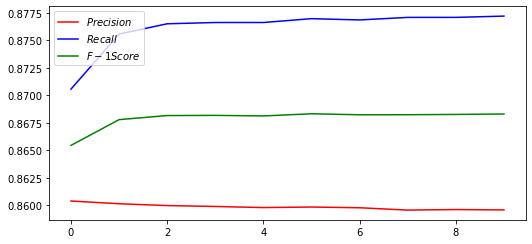

In [1178]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

#plt.plot(RMSE_list , color = 'black', label = '$RMSE$')
plt.plot(precision_list , color = 'red', label = '$Precision$')
plt.plot(recall_list , color = 'blue', label = '$Recall$')
plt.plot(f1_score_list , color = 'green', label = '$F-1 Score$')
plt.legend()